---

This Colab was initially developed by [Jonathan Spencer](https://jspencer12.github.io) for the F2020 offering of _Safety-Critical Robotic Systems_.

---

### ECE 539/COS 512, Fall 2021
# Code Demo 3 - Hamilton-Jacobi-Isaacs Reach-Avoid Analysis

What is the point of Hamilton-Jacobi-Isaacs (HJI) reach-avoid analysis? Providing *worst-case* safety and liveness guarantess.

Specifically, HJI analysis answers the question: <blockquote> **Assuming the worst case realization of my uncertainty, what is the set of states from which I am guaranteed to safely reach the goal, and what is the strategy that will allow me to do this?**</blockquote>

If we start off inside the reach-avoid set, we know that there exists no disturbance that can force us outside. While on the interior, we can choose to act optimally, perform learning, or follow an arbitrary control policy, as long as we take the appropriate control action near the boundary to ensure that we never depart from the reach-avoid set.

HJI reach-avoid analysis does this by way of a value function $V$, which implicitly encodes the possibility of safely reaching the goal at *any* future moment in time. If at state $x$ and time $t$, $V_t(x)$ is negative, then—even under the worst possible disturbance—there will exist a trajectory that can safely reach the goal. If, on the other hand $V_t(x)$ is positive, then there exists no trajectory beginning in that state which is *guaranteed* to be safe. In the limit case, when $V_t(x)$ is *exactly* zero, this means that in the worst case we will *barely* reach the goal (specified as a closed set) and/or *barely* miss the obstacles (specified as an open set).

In short, for positive $V$, there exists some disturbance that can defeat you. This analysis works even with moving obstacles and goal.

Thus the refined problem statement is: <blockquote>**Find the value function $V_t$ that encodes robustly safe and live states at time $t$.**</blockquote>

Given a terminal cost, we use the Isaacs equation to step backwards in time and find the value function for any given time.
<br><br>
$V_t = \displaystyle\min_{u_t}\max_{d_t} \max\big\{ g_t(x_t),\min\{ l_t(x_t),V_{t+1}(f_t(x_t,u_t,d_t)\}\big\} $ (discrete-time Isaacs equation)
<br><br>

In this lab we're going to walk through the HJI equation piece by piece in a way that hopefully builds some intuition.

Our recurring example will the Dubins car with bounded lateral slip disturbance $d_S$.
<center>
 <img src="https://jspencer12.github.io/images/dubins_car.png" width="350"> 
</center>

For now we'll assume constant velocity $v$, and no drag $d_D$, so rather than control $u=[a,\delta]$, we actually directly control the angle rate $\dot{\theta}=u$, with some bound $|u|\leq U_\max$.

Also note that we'll use $x$ (cursive) to denote the entire state vector, while $\textrm{x}$ (plain) is the position coordinate. We'll use $\dot{x}$ to represent the continuous time dynamics, and $f(x)$ as the discrete time state update, approximated using Forward-Euler as $x' = f(x) \simeq x + \Delta t \cdot \dot{x}$, which is valid if we keep $\Delta t$ small.

As part of that recurring example, we're going to look at a few **fixed trajectories** and consider how they compare in terms of their value functions.




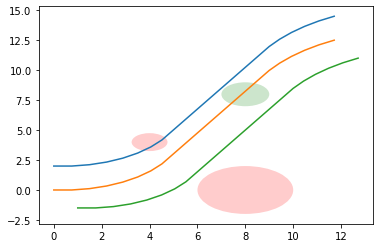

In [1]:
##################################################
###                                            ###
###        Generating Demo Trajectories        ###
###                                            ###
##################################################

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.collections import PatchCollection
import types
import time

### Define problem specs
specs = types.SimpleNamespace()               # Somewhere to store specs
specs.delta_t = .25                               # Time granularity
specs.U_max = 1                                   # Control bound
specs.D_max = .5                                  # Disturbance bound
specs.T = 6                                       # Max time
specs.vel = 3                                     # Car constant vel
specs.t_vec = np.arange(int(specs.T/specs.delta_t)+1)*specs.delta_t
                                                  # Vector of timesteps
specs.n_T = len(specs.t_vec)                      # Number of timesteps
specs.x_dim = 3                                   # State space dimension
specs.target = np.array([8,8,1])                  # Goal (x,y,radius)
specs.obstacles = np.array([[4,4,.75],[8,0,2]])   # Obstacles [(x,y,radius),...]

### Define simple constant velocity dynamics. Discretization is fine for small delta_t
def dynamics_continuous(x,u,d,specs):
    ''' x = [pos_x,pos_y,theta], u = [theta_dot]
    Designed to work if x,u,d are matrices of shape (N,3),(N),(N)
    '''
    theta = np.reshape(x,(-1,specs.x_dim))[:,2]
    theta_dot = np.reshape(np.clip(u,-specs.U_max,specs.U_max),-1)
    slip = np.clip(d,-specs.D_max,specs.D_max)
    pos_x_dot = specs.vel*np.cos(theta) + slip*np.sin(theta)
    pos_y_dot = specs.vel*np.sin(theta) + slip*np.cos(theta)
    return np.stack([pos_x_dot,pos_y_dot,theta_dot],axis=1)
def dynamics_discrete(x,u,d,specs):
  x_dot = x + specs.delta_t*dynamics_continuous(x,u,d,specs)
  x_dot[:,2] = (x_dot[:,2] + np.pi) % (2*np.pi) - np.pi  # Wrap new theta values inside +- pi
  return x_dot

### Define a few specific trajectories
U = np.zeros(specs.n_T)                   # Array for storing control sequence
U[:int(specs.n_T*.3)] = .6                # Defining some controls, writing it this way so it's invariant to delta_t
U[-int(specs.n_T*.3):] = -.4
D = np.zeros(specs.n_T)                   # Array for storing disturbance
X1 = np.zeros((specs.n_T,specs.x_dim))    # Arrays for storing state sequence
X2 = np.zeros((specs.n_T,specs.x_dim))
X3 = np.zeros((specs.n_T,specs.x_dim))
X1[0,:] = [0,2,0]
X2[0,:] = [0,0,0]                         # Set initial states
X3[0,:] = [1,-1.5,0]
trajs = [X1,X2,X3]                        # Stick trajs in list for compactness

for traj in trajs:
  for n in range(specs.n_T-1): 
    # Solve trajectories given controls and disturbance (Forward Euler is fine since delta_T small)
    traj[n+1] = dynamics_discrete(traj[n],U[n],D[n],specs)

### Plot stuff
#Stick this in a function since we'll be doing it a lot
def plot_2d_map(target,obstacles): 
  obst_coll = PatchCollection([Circle(xy=obstacles[i,:2],
                  radius=obstacles[i,2]) for i in range(len(obstacles))], facecolor='red',alpha=.2)
  targ_coll = PatchCollection([Circle(xy=target[:2],radius=target[2])], facecolor='green',alpha=.2)
  plt.gca().add_collection(obst_coll)
  plt.gca().add_collection(targ_coll)

plt.figure()
plot_2d_map(specs.target,specs.obstacles)
for traj in trajs:
  plt.plot(traj[:,0],traj[:,1])
plt.show()


## Margin Functions, Terminal Value, and Value Functions

The reach-avoid value $V(x)$ is not a value function over arbitrary cumulative costs, but is instead a "safety-liveness value function" that depends on the future distances to obstacles and the goal. The building blocks of this "safety-liveness value function" are margin functions.

### Margin functions and Terminal Value

Margin functions are not cost functions, in the sense of encoding the desirability/undesirability of being close to an object (which could have inverse square weight, etc...), rather they are *signed distance functions* to a region of the state space. In the case of an obstacle, you may wish to define the avoidance region for the obstacle to be larger than the obstacle itself.

The margin functions we use in the reach-avoid setting consist of a target margin function $\ell(x)=\textrm{dist}(x,goal)$ and an obstacle margin function $g(x) = -\textrm{dist}(x,obs)$ where $\textrm{dist}$ is a signed distance function (e.g. Euclidian) to the set. For both $g$ and $\ell$, negative is good, positive is bad; $\ell$ is negative inside the goal and $g$ is positive inside the obstacle. 

The terminal value simply asks which is the dominant margin function at the final time $t=T$. In a sense, the most positive of the two tells us how "far off" we are from success:

$V_T(x) = \max\{g_T(x),\ell_T(x)\}$.

In the reach-avoid setting, the target margin function will nearly always dominate the max. Both margin functions can represent moving targets/obstacles, so we give them an optional time dependency $g_t(x),\ell_t(x)$, and we can simply drop the time subscript to denote static targets/obstacles. In this code we only consider the static case, but the functions are defined to allow for the dynamic case.

You can see the component margin functions and terminal value for every state plotted below.


In [2]:
# Distance to target and obstacles for single state or array of states
# If you want dynamic targets/obstacles, this is the place to define their motion

def targ_margin(x,t,specs):
  x = np.reshape(x,(-1,specs.x_dim))    # Reshape so x can either be single state or array of states
  dist2targ_edge = np.linalg.norm(x[:,:2]-specs.target[:2],axis=1)-specs.target[2]
  return dist2targ_edge

def obst_margin(x,t,specs):
  x = np.reshape(x,(-1,specs.x_dim))    # Reshape so x can either be single state or array of states
  dist2all_obst_edges = [obst[2]-np.linalg.norm(x[:,:2]-obst[:2],axis=1) for obst in specs.obstacles]
  return np.max(dist2all_obst_edges,axis=0) # dominated by closest obstacle

def terminal_val(x,T,specs):           # Be sure to pass final time T
  return np.max([targ_margin(x,T,specs),obst_margin(x,T,specs)],axis=0)

In [3]:
#@markdown Function for building a 3D (can handle arbitrary dim) discrete grid with a 1D index for vectorized function evaluation. Double click to reveal.
def build_grid(ax_N,ax_extent):
  '''Build an n-dimensional uniform grid of points for use in value iteration

    Once grid coords are defined, we stick them in a 1D list for flexible indexing/
    slicing, and build a few tools for mapping between indices.

    input:
      ax_N       - list of number of points in each dimension (i.e. [11,11,11])
      ax_extent  - list of tuples of min/max value in each dim (i.e. [(-5,5),(-5,5),(-pi,pi)])

    returns grid object with the following attributes:
      state_arr  - master list of coords. State indices refer to this list  (i.e. [(-5,-5,3.14), (-5,-5,2.83),...])
      neighbors  - list of list of high/low neighbor index pairs in either 
                   direction for each dimension (i.e. [[[0, 11], [0, 451], [0, 1]], [[1, 12], [1, 452], [0, 2]], ...])
      nbr_deltas - list of lists of distance between high/low neighbor in each dim,
                   which differs at grid edge. Useful for computing gradient (i.e. [[.5,.5,.6],[.5,.5,1.2],...])
      dim_deltas - list, axis granularity in each dimension (i.e. [0.5,0.5,0.6])
      axes       - list of 1D numpy arrays, giving axis points in each dimension (i.e. [[-5,-4.5,-3,-3.5...],...])
      tup2ind    - dict mapping from tuple of axis index coords to state index   (i.e. {(0,0,0):1,(0,0,1):1,...})
      ax_N       - saves input value
      ax_extent  - saves input value
      N_states   - total number of states in grid
    '''
  grid = types.SimpleNamespace()         # Somewhere to store grid things 
  grid.ax_N = ax_N
  grid.ax_extent = ax_extent
  grid.N_states = np.product(ax_N) 
  grid.axes = [np.linspace(ax_extent[i][0],ax_extent[i][1],ax_N[i]) for i in range(len(ax_N))] #linear spaced axes in each direction
  grid.dim_deltas = np.array([ax[1]-ax[0] if len(ax)>1 else 0 for ax in grid.axes])
  grid.state_arr = np.stack([mat.flatten() for mat in np.meshgrid(*grid.axes)],axis=1)
  ind_tup_list = [*zip(*[mat.flatten() for mat in np.meshgrid(*[np.arange(N) for N in ax_N])])] #[(0,0,0), (0,0,1),...]   a list of the axis indices
  grid.tup2ind = {tup:ind for ind,tup in enumerate(ind_tup_list)}
  grid.neighbors, grid.nbr_deltas = [],[]
  for ind_tup in ind_tup_list:
    ind_neighbors = []
    ind_deltas = []
    for i in range(len(ax_N)):
      tup_low,tup_high = list(ind_tup),list(ind_tup)
      tup_low[i] = max(0,min(ax_N[i]-1,tup_low[i]-1))
      tup_high[i] = max(0,min(ax_N[i]-1,tup_high[i]+1))
      ind_neighbors.append([grid.tup2ind[tuple(tup_low)],grid.tup2ind[tuple(tup_high)]])
      ind_deltas.append(grid.axes[i][tup_high[i]]-grid.axes[i][tup_low[i]])
    grid.neighbors.append(ind_neighbors)
    grid.nbr_deltas.append(ind_deltas)
  return grid

,,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

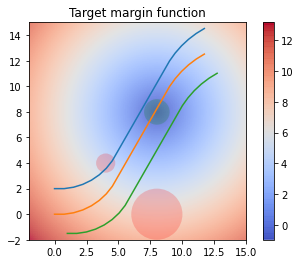

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

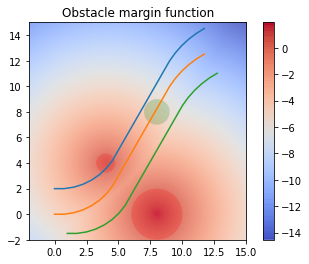

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

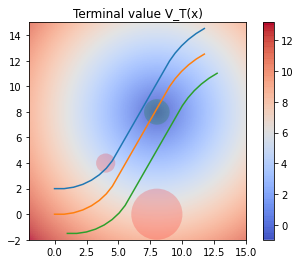

<IPython.core.display.Javascript object>

In [4]:
#@markdown ### Margin Function Visualization
#@markdown (Double click to reveal code)
from google.colab import widgets

# Make grid of x,y coords (theta=0)
ax_N = [100,100,1]
ax_extent = [[-2,15],[-2,15],[0,0]]

grid = build_grid(ax_N,ax_extent)

# Evaluate functions
titles = ['Target margin function',
          'Obstacle margin function',
          'Terminal value V_T(x)']
margins = [targ_margin(grid.state_arr,specs.T,specs),
           obst_margin(grid.state_arr,specs.T,specs),
           terminal_val(grid.state_arr,specs.T,specs)]

# Plot
img_extent = [*ax_extent[0],*ax_extent[1]]
plt_grid = widgets.Grid(1,3)
for i, (r,c) in enumerate(plt_grid):
  plt.figure()
  plt.title(titles[i])
  plt.imshow(np.reshape(margins[i],ax_N[:2]), extent=img_extent,
             origin='lower',alpha=.8,cmap='coolwarm')
  plt.colorbar()
  plot_2d_map(specs.target,specs.obstacles)
  for traj in trajs:
    plt.plot(traj[:,0],traj[:,1])
  plt.show()

### Reachability

Consider the reachability setting where we only care about the target margin function:

$V_t(x) = \min\big\{\ell(x),V_{t+1}(x)\big\}~~~$ and $~~~V_T(x)=\ell_T(x)$

We will later consider the value for an optimal set of controls, but for now consider the fixed control sequences we defined earlier. For a given state $x$, $V_t(x)$ represents the closest we will reach the target in the future. If $V_t(x)$ is negative, that means that at some future time we'll hit the target.

Now, we will plot $\ell(x)$ and $V(x)$ for a few trajectories. Notice which trajectories have negative values, which do not, and think about why. Also notice that at some point the value functions begin to increase, because looking forward they will never be closer to the target than they are at that point.

In [5]:
#########################
#### Coding exercise ####
#########################
#
# Solve for the time-evolution of the *reachability* value.
#
# Given our three demo trajectories stored in "trajs", write some code to find
# how the value of each of those trajectories evolves over time, and place
# the result in the list below. The value sequences should be the same length as
# the trajectories. There is some code below to get you started.

# You'll probably want to use these
# specs.T         real number final time
# specs.t_vec     vector of time discretization
# targ_margin     function of x,t,specs for computing the target margin value

reachability_values = []
for i,traj in enumerate(trajs):
  V = np.zeros(specs.n_T)                             # Init V with all zeros
  ### Populate me! ###

  reachability_values.append(V)

In [6]:
#@markdown \*\*Hidden Demo Code\*\* (see prev cell for instructions)
def reachability_bellman_update(V_tplus1,x_t,t):
  return min(targ_margin(x_t,t,specs),V_tplus1)

reachability_values = []
for i,traj in enumerate(trajs):

  #### Dynamic Programming for Reachability
  V = np.zeros(specs.n_T)                             # Init V with all zeros
  V[-1] = targ_margin(traj[-1,:],specs.T,specs)       # Init terminal value
  for t in reversed(range(specs.n_T-1)):              # Step backward in time
    V[t] = reachability_bellman_update(V[t+1],traj[t,:],specs.t_vec[t])

  reachability_values.append(V)

,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

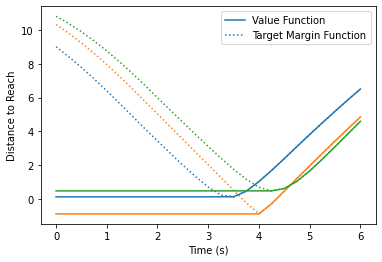

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

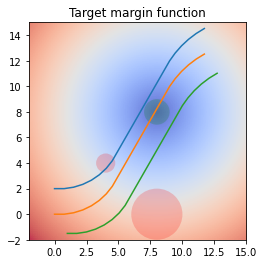

<IPython.core.display.Javascript object>

In [7]:
#@markdown ### Visualizing Reachability Value Over Time for Fixed Trajectories
#@markdown Run this after solving the coding exercise (Double click to reveal boring plotting code)

colors = plt.cm.get_cmap('tab10').colors      #grab a nice colormap

plt_grid = widgets.Grid(1,2)

# Plot value evolution for each demo traj
with plt_grid.output_to(0, 0):
  for i in range(len(trajs)):
    # Plot things
    plt.plot(specs.t_vec,reachability_values[i],c=colors[i])
    plt.plot(specs.t_vec,targ_margin(trajs[i],specs.t_vec,specs),
             ls=':',c=colors[i])
  plt.legend(['Value Function','Target Margin Function'])
  plt.xlabel('Time (s)')
  plt.ylabel('Distance to Reach')
  plt.show()

# Re-plot target margin func for reference 
with plt_grid.output_to(0, 1):
  plt.figure()
  plt.title('Target margin function')
  plt.imshow(np.reshape(targ_margin(grid.state_arr,specs.T,specs),ax_N[:2]),
             extent=img_extent,origin='lower',alpha=.8,cmap='coolwarm')
  plot_2d_map(specs.target,specs.obstacles)
  for traj in trajs:
    plt.plot(traj[:,0],traj[:,1])
  plt.show()


### Avoidance

Now let us instead consider the collision avoidance margin function

$V_t(x) = \max\big\{g(x),V_{t+1}(x)\big\}~~~$ and $~~~V_T(x)=g_T(x)$

Similar to the reachability, $V_t(x)$ represents the closest I will approach an obstacle at any point in the future. So $V_t(x)=-1$ means that now or at some point in the future I will be 1m away from an obstacle. Decreasing value functions here mean that at no point in the future will I be closer to the obstacle than I am now. Reflect here, too, on the meaning of negative vs positive values.

In [8]:
#########################
#### Coding exercise ####
#########################
#
# Solve for the time-evolution of the *avoidance* value.
#
# Given our three demo trajectories stored in "trajs", write some code to find
# how the value of each of those trajectories evolves over time, and place
# the result in the list below. The value sequences should be the same length as
# the trajectories. There is some code below to get you started.

# You'll probably want to use these
# specs.T         real number final time
# specs.t_vec     vector of time discretization
# obst_margin     function of x,t,specs for computing obstacle margin value

avoidance_values = []
for i,traj in enumerate(trajs):
  V = np.zeros(specs.n_T)                             # Init V with all zeros
  ### Populate me! ###

  avoidance_values.append(V)

In [9]:
#@markdown \*\*Hidden Demo Code\*\* (see previous cell for instructions)
def avoidance_bellman_update(V_tplus1,x_t,t):
  return max(obst_margin(x_t,t,specs),V_tplus1)

avoidance_values = []
for i,traj in enumerate(trajs):

  #### Dynamic Programming for Avoidance
  V = np.zeros(specs.n_T)                             #Init empty V
  V[-1] = obst_margin(traj[-1,:],specs.T,specs)       #Init terminal value
  for t in reversed(range(specs.n_T-1)):              #Step backward in time
    V[t] = avoidance_bellman_update(V[t+1],traj[t,:],specs.t_vec[t])

  avoidance_values.append(V)

,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

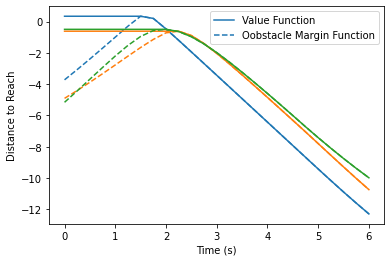

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

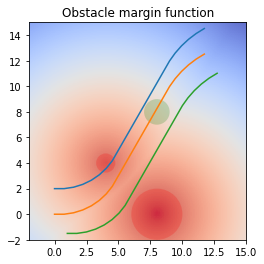

<IPython.core.display.Javascript object>

In [10]:
#@markdown ### Visualizing Avoidance Value Over Time for Fixed Trajectories
#@markdown Run this after solving the coding exercise (Double click to reveal boring plotting code)

colors = plt.cm.get_cmap('tab10').colors      #grab a nice colormap

plt_grid = widgets.Grid(1,2)

# Plot value evolution for each demo traj
with plt_grid.output_to(0, 0):
  for i in range(len(trajs)):
    # Plot things
    plt.plot(specs.t_vec,avoidance_values[i],c=colors[i])
    plt.plot(specs.t_vec,obst_margin(trajs[i],specs.t_vec,specs),
             ls='--',c=colors[i])
  plt.legend(['Value Function','Oobstacle Margin Function'])
  plt.xlabel('Time (s)')
  plt.ylabel('Distance to Reach')
  plt.show()

# Re-plot target margin func for reference 
with plt_grid.output_to(0, 1):
  plt.figure()
  plt.title('Obstacle margin function')
  plt.imshow(np.reshape(obst_margin(grid.state_arr,specs.T,specs),ax_N[:2]),
             extent=img_extent,origin='lower',alpha=.8,cmap='coolwarm')
  plot_2d_map(specs.target,specs.obstacles)
  for traj in trajs:
    plt.plot(traj[:,0],traj[:,1])
  plt.show()


### Reach-Avoid

In both Reachability and Avoidance settings, the value function has a very concrete meaning: the closest I will approach target/goal in the future. In both cases, a value of zero is the threshold of attaining the goal/avoiding the obstacle.

In the reach-avoid problem, the value function loses a little bit of its intuition as we are concerned with both avoiding the obstacles **and** reaching the goal. 

$V_t(x) = \max\big\{g(x),\min\big\{\ell(x),V_{t+1}(x)\big\}\big\}~~~$ and $~~~V_T(x)=\max\{g_T(x),\ell_T(x)\}$

Value in the reach-avoid setting tells me about the dominant effect. Saying that $V(x)=1$ means that at some point in the future I will either come within 1m of the goal or penetrate 1m into an obstacle. Which term is dominating is ambiguous unless you look at the time-evolution of the value function. Despite this ambiguity, the reach-avoid value function is very useful because a negative value of $V_t(x)$ tells us that at some point in the future we have both avoided all future obstacles and reached the goal.

Notice in the plots below that there is a trough in some of the value functions. This trough occurs when the dominant cost switches. Looking backwards in time, initially the target margin function is the dominant cost because the trajectories are closer to the target than they are far from the obstacles. But as they pass the target and approach the obstacles, those terms become more dominant.

For the orange trajectory below, this switching dominance means that I got closer to the obstacle boundary (-0.6m) than I was deep inside of the target (-1m).

Think about that concept for a bit until it sinks in. But also remember that those details don't really matter because the whole point of this analysis is that **wherever the value function is negative, I am guaranteed to safely reach the target in the future**. So, we really only care about the sign of $V(x)$.

Before you move on, think about how the design of these margin functions and the choice of min/max encodes "anytime" and "until" logical operators.

In [11]:
#########################
#### Coding exercise ####
#########################
#
# Solve for the time-evolution of the *reach-avoid* value.
#
# Given our three demo trajectories stored in "trajs", write some code to find
# how the value of each of those trajectories evolves over time, and place
# the result in the list below. The value sequences should be the same length as
# the trajectories. There is some code below to get you started.

# You'll probably want to use these
# specs.T         real number final time
# specs.t_vec     vector of time discretization
# targ_margin     function of x,t,specs for computing target margin value
# obst_margin     function of x,t,specs for computing obstacle margin value

reach_avoid_values = []
for i,traj in enumerate(trajs):
  V = np.zeros(specs.n_T)                             # Init V with all zeros
  ### Populate me! ###

  reach_avoid_values.append(V)

In [12]:
#@markdown \*\*Hidden Demo Code\*\* (see previous cell for instructions)
def reach_avoid_bellman_update(V_tplus1,x_t,t):
  return max(obst_margin(x_t,t,specs), min(targ_margin(x_t,t,specs),V_tplus1))

reach_avoid_values = []
for i,traj in enumerate(trajs):

  #### Dynamic Programming for Reach Avoid
  V = np.zeros(specs.n_T)                             #Init empty V
  V[-1] = targ_margin(traj[-1,:],specs.T,specs)       #Init terminal value
  for t in reversed(range(specs.n_T-1)):              #Step backward in time
    V[t] = reach_avoid_bellman_update(V[t+1],traj[t,:],specs.t_vec[t])

  reach_avoid_values.append(V)

,,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

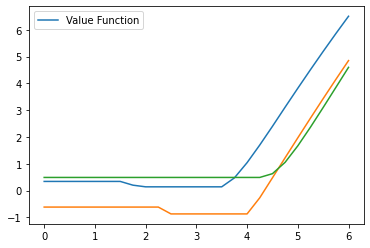

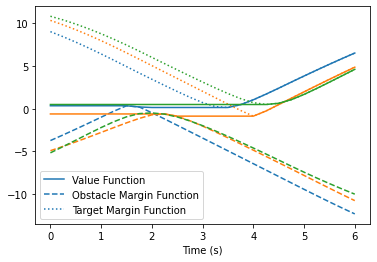

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

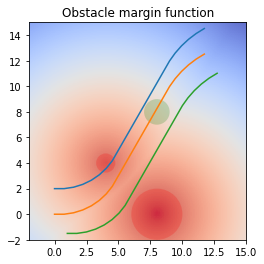

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

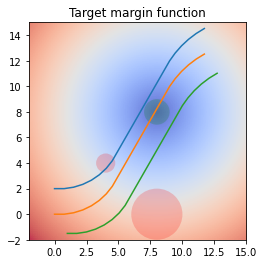

<IPython.core.display.Javascript object>

In [13]:
#@markdown ### Visualizing Avoidance Value Over Time for Fixed Trajectories
#@markdown Run this after solving the coding exercise (Double click to reveal boring plotting code)

colors = plt.cm.get_cmap('tab10').colors      #grab a nice colormap

plt_grid = widgets.Grid(1,3)

# Plot value evolution for each demo traj
with plt_grid.output_to(0, 0):
  for i in range(len(trajs)):
    # Plot things
    plt.figure('value')
    plt.plot(specs.t_vec,reach_avoid_values[i],c=colors[i])
    plt.figure('value-margin')
    plt.plot(specs.t_vec,reach_avoid_values[i],c=colors[i])
    plt.plot(specs.t_vec,obst_margin(trajs[i],specs.t_vec,specs),
             ls='--',c=colors[i])
    plt.plot(specs.t_vec,targ_margin(trajs[i],specs.t_vec,specs),
             ls=':',c=colors[i])
  plt.figure('value')
  plt.legend(['Value Function'])
  plt.figure('value-margin')
  plt.legend(['Value Function','Obstacle Margin Function','Target Margin Function'])
  plt.xlabel('Time (s)')
  plt.show()

# Re-plot target and obstacle margin func for reference 
with plt_grid.output_to(0, 1):
  plt.figure()
  plt.title('Obstacle margin function')
  plt.imshow(np.reshape(obst_margin(grid.state_arr,specs.T,specs),ax_N[:2]),
             extent=img_extent,origin='lower',alpha=.8,cmap='coolwarm')
  plot_2d_map(specs.target,specs.obstacles)
  for traj in trajs:
    plt.plot(traj[:,0],traj[:,1])
  plt.show()

with plt_grid.output_to(0, 2):
  plt.figure()
  plt.title('Target margin function')
  plt.imshow(np.reshape(targ_margin(grid.state_arr,specs.T,specs),ax_N[:2]),
             extent=img_extent,origin='lower',alpha=.8,cmap='coolwarm')
  plot_2d_map(specs.target,specs.obstacles)
  for traj in trajs:
    plt.plot(traj[:,0],traj[:,1])
  plt.show()


## Optimal Reach-Avoid

The previous sections dealt with understanding the change in value function for fixed controls. Now let us consider how to search for the *optimal* set of controls in order to minimize the true value function, while still assuming zero disturbance. The states within the zero level set of $V$ are those which will safely reach the target, as long as they choose the optimal controls $u^*$ (or any control $u$ which decreases the value function).

Doing so will require that we perform the bellman backup for every single state at every time-step.
<br><br>
$V_t(x_t) = \max\big\{ g_t(x_t),\min\{ l_t(x_t),\displaystyle\min_{u_t} V_{t+1}(f_t(x_t,u_t)\}\big\} ~~\forall x \in \mathcal{X}, \forall t\in [0,T-1]$
<br><br>

#### Finding the set of optimal controls

Often in a discretized environment, the solution to the minimization is simple: find the gradient of the value function $V_{t+1}$, then choose $u$ that minimizes it. As you'll see, when we know the dynamics, the minimization typically has a nice, closed-form solution.

The terms of the value function gradeint are often called the co-state $\nabla_x V = [p_\textrm{x},p_\textrm{y},p_\theta]$. (Technically that's for the Hamiltonian, but we'll stretch the term a little and use it here.) The co-state will be a tuple of scalar values that we solve for by computing the gradient numerically.

We're going to drop the time indices here since we really only care about the current state $x$ and the next state $x'$, and since time is discrete, we'll only be taking a small $\Delta t$ step: $x' = f(x,u) \simeq x + \Delta t \cdot \dot{x}(x,u)$.

$\begin{align}
u^* &= \arg\min_u~V(f(x,u,d)) \\
 &\simeq \arg\min_u~V(x) + \Delta t \cdot\nabla_x V^T\dot{x}(x,u) \\
 &= \arg\min_u~\nabla_x V^T\dot{x}(x,u) \\
 &= \arg\min_u~p_\textrm{x}\cdot\dot{\textrm{x}}+p_\textrm{y}\cdot\dot{\textrm{y}}+p_\theta\cdot\dot{\theta}
\end{align}$

Since the only term that depends on $u$ is the $\dot{\theta}$ term, this becomes super simple (applying constraint $|u|\leq U_{max}$).

$\begin{align}
u^* &= \arg\min_u~p_\theta\cdot u \\
 &= \frac{-p_\theta}{\|p_\theta\|} U_{max},\quad 
\end{align}$

Notice that for scalars, $x/\|x\|$ is equivalent to the $\textrm{sign}(x)$ function, so in this solution we are always applying maximum control or disturbance. The optimal controller is typically a  "bang-bang" style controller.

In building a grid, we have defined a discrete set of states at which the value function is numerically specified. However, in pushing through the dynamics, the corresponding next states $x'$ that result from the optimal controls might not fall exactly on the grid, so we must interpolate $V(x)$ to find $V(f(x,u^*))$.

Our solution approach is then the following:
1. Compute spatial gradient $\nabla_x V_{t+1}(x)~\forall x$ so we have co-states.
2. Compute analytic solutions for $u^*$, and push through dynamics to find $x'=f(x,u^*)$.
3. Return $V_{t+1}(x')$, interpolating between grid points as needed.

#### Finding the Value Function

Once we know how to find the optimal control, finding the value function is straightforward. We simply build a discrete grid over the state space (denote $\mathcal{I}$ as the set of grid points), compute the value function everywhere, back up to the previous timestep, and repeat. In pseudocode this is:
<br><blockquote>
$\begin{align}
&\textrm{Dynamic Programming on a Grid}\\
&\text{for}~x_i \in \mathcal{I}:\\
&~~~V_T(x_i) \leftarrow \max(g_T(x_i),\ell_T(x_i)) \qquad \textrm{(terminal value)}\\
&\text{for}~t = [T-1,...,0]:\\
&~~~\text{for}~x_i \in \mathcal{I}:\\
&~~~~~~V_t(x_i) \leftarrow \max\Big\{g_t(x_i),\min\Big\{\ell_t(x_i),\min_u V_{t+1}(f_t(x_i,u))\Big\}\Big\}
\end{align}$
</blockquote>

See below for the Python implementation.






In [14]:
#@markdown Function for performing vectorized interpolation of many points simultanously. Double click to reveal.
from itertools import product

def interpolate(X,V_vec,grid):
  '''
  Interpolate function V(x) when V is defined on points grid.state_arr as V_vec

  In 1D, to interpolate a function defined at a and b, a < x < b
    V(x) = (1-lam)V(a) + lam*V(b) where lam =(x-a)/(b-a),
  this is an x_dim generalization

  input:
    X           - state or array of states over which we wish to interpolate V
    grid
     .state_arr - 2D array, rows corresponding to every state in grid.
     .axes      - list of discrete arrays for each discretized axis
     .tup2ind   - dict mapping from axis index tuples to global state ind i.e. tup2ind[(5,3,7)] = 114
    V_vec       - 1D array, evaluations of V for each corresponding grid point
  output:
    V_interp    - 1D array, interpolated values of V for each state in x
  '''
  
  X = np.reshape(X,(-1,len(grid.axes))) # X should be of shape (n_pts,x_dim) even if n_pts is 1
  n_pts,x_dim = X.shape
  # First find upper/lower neighbor ind for all points,
  # np.searchsorted returns the index where x would be inserted in the discrete axis array
  # upper is (n_pts,x_dim), [[ax0_upper,ax1_upper,ax2_upper],...]
  # both is (n_pts,x_dim,2), each row is [[ax0_upper,ax0_lower],[ax1_upper,ax1_lower],[ax2_lower,ax2_upper]]
  upper_inds = np.stack([np.minimum(np.searchsorted(grid.axes[i],X[:,i]),grid.ax_N[i]-1) for i in range(x_dim)],axis=1)
  lower_inds = np.stack([np.minimum(np.searchsorted(grid.axes[i],X[:,i]-grid.dim_deltas[i]),grid.ax_N[i]-1) for i in range(x_dim)],axis=1)
  both = np.stack([upper_inds,lower_inds],axis=2) 

  # Find global state index for every neighbor of each n_pts point in x by 
  #   looking at the product space of all upper and lower indices
  # product(a,b,c,...) iterates over all tuple combinations of the elements of a,b,c,...
  neighbors = [[grid.tup2ind[ax_ind_tup] for ax_ind_tup in product(*both[i,:])] for i in range(n_pts)] 
  
  # Find corresponding weight to apply to each neighbor by finding normalized distance
  #   between x and upper/lower neighbors along each axis, then taking the product
  #   of all axis distances to get weight for each neighbor
  #   For a<x<b,   V(x) = (1-lambda)V(a) + lambda*V(b) where lambda =(x-a)/(b-a)
  #   Here we are finding lambda
  upper_ax_coords = np.stack([grid.axes[i][upper_inds[:,i]] for i in range(x_dim)],axis=1) #(n_pts,x_dim), real number values of "b" in each dim
  lower_ax_coords = np.stack([grid.axes[i][lower_inds[:,i]] for i in range(x_dim)],axis=1) #(n_pts,x_dim), real number values of "a" in each dim
  # ax_dists are our 1D lamdas for each dim: (n_pts,x_dim,2) [[1-lam_ax0,lam_ax0],[1-lam_ax1,lam_ax1],[1-lam_ax2,lam_ax2]]
  ax_dists = np.stack([1-(X-lower_ax_coords)/grid.dim_deltas,(X-lower_ax_coords)/grid.dim_deltas],axis=2)
  # weight for each neighbor is just product of normalized axis "lambda" distances between neighbor and x
  weights = np.array([[np.prod(w_tup) for w_tup in product(*ax_dists[i,:])] for i in range(n_pts)])

  # Interpolated value for each point is the value at each neighbor weighted by the proper distance weight
  V_interp = np.array([np.inner(V_vec[neighbors[i]],weights[i]) for i in range(n_pts)])
  return V_interp

# Helper function to make sure our grid is adequately dense
def check_appropriate_resolution(specs,grid):
  if specs.vel<np.sqrt(grid.dim_deltas[0]**2+grid.dim_deltas[1]**2)/specs.delta_t:
    print('Warning: Grid too coarse for information propagation, results may be inaccurate')
    print('Want vel >= max(dx,dy)/dt. Consider increasing vel,dt or increasing grid N')
    print(f'Current vel:{specs.vel}, dt:{specs.delta_t}, dx/dy hypotenuse:{np.sqrt(grid.dim_deltas[0]**2+grid.dim_deltas[1]**2)}')


#### Optimal Reach-Avoid Problem Setup

In [15]:
### Redefine problem specs here so they're easy to edit
specs = types.SimpleNamespace()               # Somewhere to store specs
specs.delta_t = .25                               # Time granularity
specs.U_max = 1                                   # Control bound
specs.D_max = .6                                  # Disturbance bound
specs.T = 5                                       # Max time
specs.vel = 3                                     # Car constant vel
specs.t_vec = np.arange(int(specs.T/specs.delta_t)+1)*specs.delta_t
                                                  # Vector of timesteps
specs.n_T = len(specs.t_vec)                      # Number of timesteps
specs.x_dim = 3                                   # State space dimension
specs.target = np.array([8,8,1])                  # Goal (x,y,radius)
specs.obstacles = np.array([[4,4,.75],[8,0,2]])   # Obstacles [(x,y,radius),...]

#### Define discrete grid
ax_N = [41,41,11]                                #Number of points in each dimension
ax_extent = [[-5,15],[-5,15],[-np.pi,np.pi]]     #Dimension sizes
grid = build_grid(ax_N,ax_extent)

# Helper function to make sure our grid is adequately dense
check_appropriate_resolution(specs,grid)

def min_u(V_vec,grid,specs):
  '''
  For some state x want to compute min_u max_d V(f(x,u,d))
  '''
  # First compute spatial gradient of V at each point
  V_grad = np.array([[np.diff(V_vec[grid.neighbors[j][i]])[0]/grid.nbr_deltas[j][i] for i in range(specs.x_dim)] for j in range(grid.N_states)])

  # Find optimal control
  u = specs.U_max * np.sign(-V_grad[:,2])

  # Push minmax solution through dynamics (no disturbance) and interpolate
  x_prime = dynamics_discrete(grid.state_arr,u,d=0,specs=specs)
  V_interp = interpolate(x_prime,V_vec,grid)
  return V_interp

#### Optimal Reach-Avoid Dynamic Programming Computation

In [16]:
start = time.time()
###################################
#  Dynamic Programming on a Grid  #
###################################

V = np.zeros((grid.N_states,specs.n_T))                 # Populate empty value function
V[:,specs.n_T-1] = terminal_val(grid.state_arr,specs.T,specs)   # Initialize terminal cost
for t in reversed(range(specs.n_T-1)):                  # Step backwards in time to find value function for all time
  V[:,t] = np.max([obst_margin(grid.state_arr,specs.t_vec[t],specs),
                   np.min([targ_margin(grid.state_arr,specs.t_vec[t],specs),
                           min_u(V[:,t+1],grid,specs)],axis=0)],axis=0)
  
  # With slow code it's nice to print a progress update.
  # print('\rSomething to update',end='') rewrites over the same line over and over
  print('\rComputing Value Function - {:0.0%} done ({:.1f} seconds)'.format(1-t/(specs.n_T-1),time.time()-start),end='')
print('\rFinished computing value function after {:.1f} seconds'.format(time.time()-start))
print('Run the next cell to visualize it.')


## Reshape/reindex V for quick plotting
plt_extent = [*grid.ax_extent[0],*grid.ax_extent[1]]
V_plot = np.zeros((*grid.ax_N,specs.n_T))
for t_ind in range(specs.n_T):
  V_plot[:,:,:,t_ind] = np.reshape(V[:,t_ind],grid.ax_N) 
V_every_ang = np.sign(np.sum(np.sign(V_plot)+1,axis=2)-1)
V_any_ang = np.sign(np.product(np.sign(V_plot)+1,axis=2)-1)


Finished computing value function after 38.2 seconds
Run the next cell to visualize it.


Below we can visualize the solved value function. The level set where $V_t(x)=0$ represents the set of states from which it is _barely_ possible to reach the goal by time $T$.

You can use the sliders to visualize how this evolves as a function of time, starting with the final time $t=T$ (if you change $T$ in the code, be sure to change it on the slider max, which is unfortunately non-parametrizable)

,,,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

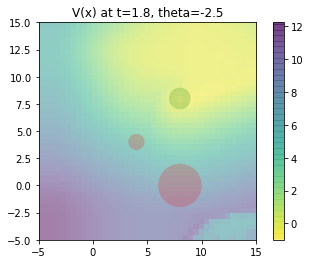

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

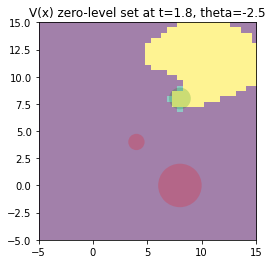

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

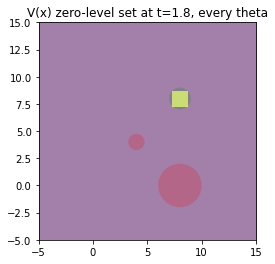

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

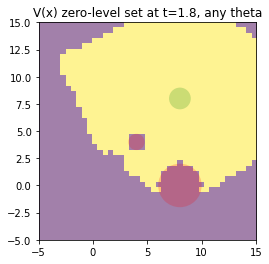

<IPython.core.display.Javascript object>

In [17]:
#@title Visualizing the Value Function {run: "auto"}
#@markdown (Double click here to reveal plotting code) 
theta = -2.82# @param {type:"slider", min:-3.14, max:3.14,step:0.01}
t = 1.75 # @param {type:"slider", min:0, max:5,step:0.01}

#Snap slider input to grid
theta_ind = np.argmin(np.abs(grid.axes[2]-theta))
t_ind = np.argmin(np.abs(specs.t_vec-t))
theta_val,t_val = grid.axes[2][theta_ind],specs.t_vec[t_ind]

#Build images
titles = [f'V(x) at t={t_val:.1f}, theta={theta_val:.1f}',
          f'V(x) zero-level set at t={t_val:.1f}, theta={theta_val:.1f}',
          f'V(x) zero-level set at t={t_val:.1f}, every theta',
          f'V(x) zero-level set at t={t_val:.1f}, any theta',]
imgs = [V_plot[:,:,theta_ind,t_ind],
        np.sign(V_plot[:,:,theta_ind,t_ind]),
        V_every_ang[:,:,t_ind],
        V_any_ang[:,:,t_ind]]

#Plot
plt_grid = widgets.Grid(1,4)
for i, (r,c) in enumerate(plt_grid):
  plt.title(titles[i])
  plt.imshow(imgs[i],extent=plt_extent,origin='lower',alpha=.5,cmap='viridis_r')
  if i==0:
    plt.colorbar()
  plot_2d_map(specs.target,specs.obstacles)
plt.show()

## Reach-Avoid With Worst-Case Disturbance

Until now we have seen that this framework can show us the states from which we will reach the target and avoid the obstacles, but the real power of the HJI equations is to combine this with worst-case disturbances and find the **robust** reach-avoid set: the set of states that will reach the target under worst-case disturbance. The full Isaacs equation (discrete-time HJI equation) is:
<br><br>
$V_t(x_t) = \max\big\{ g_t(x_t),\min\{ l_t(x_t),\displaystyle\min_{u_t}\max_{d_t}V_{t+1}(f_t(x_t,u_t,d_t)\}\big\} $
<br><br>
Thus, finding the robust reach-avoid set requires that we solve the point-wise min-max game
$\displaystyle\min_u \max_d V_{t+1}(f_t(x_t,u,d)\}$
at each timestep $t$ and state $x_t$.

#### Solving the min-max game

So, how to choose $u$ and $d$ to solve the min-max game? We do so in a very similar way as finding the optimal control. Let's first find the minimizing controls and maximizing disturbances, and then we'll plug those values into the dynamics and take a tiny step forward. Dropping the time index as before, we have:
<br><br>
$\begin{align}
(u^*,d^*) &= \arg\min_u \max_d V(f(x,u,d)) \\
 &\simeq \arg\min_u \max_d~ V(x) + \Delta t \cdot\nabla_x V^T\dot{x}(x,u,d) \\
 &= \arg\min_u \max_d~\nabla_x V^T\dot{x}(x,u,d) \\
 &= \arg\min_u \max_d~p_\textrm{x}\cdot\dot{\textrm{x}}+p_\textrm{y}\cdot\dot{\textrm{y}}+p_\theta\cdot\dot{\theta}
\end{align}$

Luckily for us, the control and disturbance terms are independent, so the min-max splits into a sum with no coupling, we get the same solution as before for $u$, and the following for $d$:

$\begin{align}
(u^*,d^*) &= \arg\min_u \max_d~p_x\cdot(v \cos(\theta) +d \sin(\theta))+p_y(v \sin(\theta) +d \cos(\theta))+p_\theta\cdot u \\
(u^*,d^*) &= \big(\arg\min_u p_\theta\cdot u ,\;\; \arg\max_d~d(p_x \sin(\theta)+p_y \cos(\theta)) \big)
\end{align}$

Applying the constraints $|u|\leq U_{max}$ and $|d|\leq D_{max}$ we reach the following solution:

$u^* = \frac{-p_\theta}{\|p_\theta\|} U_{max},\quad
 d^* = \frac{p_x \sin(\theta)+p_y \cos(\theta)}{\|p_x \sin(\theta)+p_y \cos(\theta)\|} D_{max}.$
<br><br>

The implementation is nearly identical as the no disturbance case. Following the solution above, try to implement the `min_u_max_d` function yourself.

In [18]:
#########################
#### Coding exercise ####
#########################
#
# Implement the function which evaluates the value function after minimax optimal controls
#
# You'll probably want to use these
# grid.neighbors    list of list of [lower,upper] neighbor state inds for every state in grid in each dimension
# grid.nbr_deltas   list of list of distance between upper,lower for each dimension (uniform except at grid edge)
# dynamics_discrete function of x,u,d,specs for performing a discrete state update
# interpolate       function of X,V_vec,grid for interpolating V_vec for all states in X

def min_u_max_d(V_vec,grid,specs):
  '''
  For each state x in grid, to compute min_u max_d V(f(x,u,d))

  V_vec is a vector of length N, corresponding to the N states in grid.state_arr.
  The returned minimax value should have the same form as V_vec.
  '''
  ### Populate me! ###
  return np.zeros_like(V_vec)  # Placeholder return: change me!

In [19]:
#@markdown \*\*Hidden Demo Code\*\* (see previous cell for instructions)
def min_u_max_d(V_vec,grid,specs):
  '''
  For each state x in grid, to compute min_u max_d V(f(x,u,d))

  V_vec is a vector of length N, corresponding to the N states in grid.state_arr
  The functions are written so as to solve for all states at the same time, rather
  than iterating over them. If V is discretized and defined only at points on
  grid.state_arr, we must interpolate since the x'=f(x,u,d) will likely not fall
  directly on grid locations.
  '''
  #First compute spatial gradient of V at each point
  V_grad = np.array([[np.diff(V_vec[grid.neighbors[j][i]])[0]/grid.nbr_deltas[j][i] for i in range(specs.x_dim)] for j in range(grid.N_states)])

  u = specs.U_max * np.sign(-V_grad[:,2])
  d = specs.D_max * np.sign(V_grad[:,0]*np.sin(grid.state_arr[:,2])+V_grad[:,1]*np.cos(grid.state_arr[:,2]))

  # Push minmax solution through dynamics and interpolate
  X_prime = dynamics_discrete(grid.state_arr,u,d,specs)
  V_interp = interpolate(X_prime,V_vec,grid)
  return V_interp

#### Minimax Reach-Avoid Game Setup

In [20]:
### Redefine problem specs here so they're easy to edit
specs = types.SimpleNamespace()               # Somewhere to store specs
specs.delta_t = .25                               # Time granularity
specs.U_max = 1                                   # Control bound
specs.D_max = .6                                  # Disturbance bound
specs.T = 5                                       # Max time
specs.vel = 3                                     # Car constant vel
specs.t_vec = np.arange(int(specs.T/specs.delta_t)+1)*specs.delta_t
                                                  # Vector of timesteps
specs.n_T = len(specs.t_vec)                      # Number of timesteps
specs.x_dim = 3                                   # State space dimension
specs.target = np.array([8,8,1])                  # Goal (x,y,radius)
specs.obstacles = np.array([[4,4,.75],[8,0,2]])   # Obstacles [(x,y,radius),...]

#### Define discrete grid
ax_N = [41,41,11]                                #Number of points in each dimension
ax_extent = [[-5,15],[-5,15],[-np.pi,np.pi]]     #Dimension sizes
grid = build_grid(ax_N,ax_extent)

# Helper function to make sure our grid is adequately dense
check_appropriate_resolution(specs,grid)

#### Minimax Reach-Avoid Dynamic Programming Computation

In [21]:
start = time.time()

###################################
#  Dynamic Programming on a Grid  #
###################################

V = np.zeros((grid.N_states,specs.n_T))                 # Populate empty value function
V[:,specs.n_T-1] = terminal_val(grid.state_arr,specs.T,specs)   # Initialize terminal cost
for t in reversed(range(specs.n_T-1)):                  # Step backwards in time to find value function for all time
  V[:,t] = np.max([obst_margin(grid.state_arr,specs.t_vec[t],specs),
                   np.min([targ_margin(grid.state_arr,specs.t_vec[t],specs),
                           min_u_max_d(V[:,t+1],grid,specs)],axis=0)],axis=0)
  
  print('\rComputing Value Function - {:0.0%} done ({:.1f} seconds)'.format(1-t/(specs.n_T-1),time.time()-start),end='')
print('\rFinished computing value function after {:.1f} seconds'.format(time.time()-start))
print('Run the next cell to visualize it.')


## Reshape/reindex V for quick plotting
plt_extent = [*grid.ax_extent[0],*grid.ax_extent[1]]
V_plot = np.zeros((*grid.ax_N,specs.n_T))
for t_ind in range(specs.n_T):
  V_plot[:,:,:,t_ind] = np.reshape(V[:,t_ind],grid.ax_N) 
V_every_ang = np.sign(np.sum(np.sign(V_plot)+1,axis=2)-1)
V_any_ang = np.sign(np.product(np.sign(V_plot)+1,axis=2)-1)


Finished computing value function after 38.2 seconds
Run the next cell to visualize it.


This time, the level set where $V_t(x)=0$ represents the set of states from which it is possible to reach the goal by time $T$ in the presence of *any* potential disturbance.

Try adjusting the value for `D_max`, the bound on the disturbance and notice how the reachable set changes. You'll have to run the Dynamic Programming block again.

Compare this solution with the one in the no-disturbance case. Note that right now the coarse discretization gives us pretty inexact solutions. If you increase the resolution, be sure to do so to a similar degree for x, y, theta, and time (and keep in mind that the _curse of dimensionality_ applies here, so doubling the 4D grid's resolution will roughly multiply the number of operations by $2^4 = 16$).

,,,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

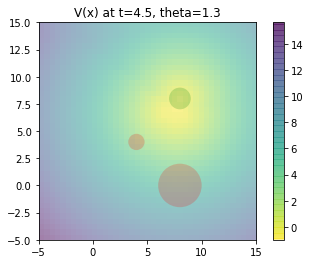

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

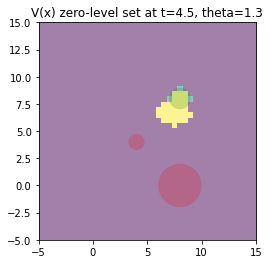

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

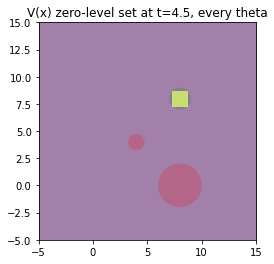

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

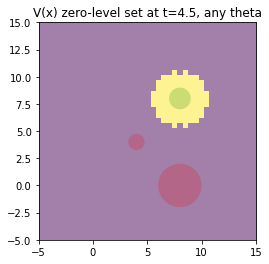

<IPython.core.display.Javascript object>

In [22]:
#@title Visualizing the Value Function {run: "auto"}
#@markdown (Double click here to reveal plotting code)
theta = 1.11# @param {type:"slider", min:-3.14, max:3.14,step:0.01}
t = 4.46 # @param {type:"slider", min:0, max:5,step:0.01}

#Snap slider input to grid
theta_ind = np.argmin(np.abs(grid.axes[2]-theta))
t_ind = np.argmin(np.abs(specs.t_vec-t))
theta_val,t_val = grid.axes[2][theta_ind],specs.t_vec[t_ind]

#Build images
titles = [f'V(x) at t={t_val:.1f}, theta={theta_val:.1f}',
          f'V(x) zero-level set at t={t_val:.1f}, theta={theta_val:.1f}',
          f'V(x) zero-level set at t={t_val:.1f}, every theta',
          f'V(x) zero-level set at t={t_val:.1f}, any theta',]
imgs = [V_plot[:,:,theta_ind,t_ind],
        np.sign(V_plot[:,:,theta_ind,t_ind]),
        V_every_ang[:,:,t_ind],
        V_any_ang[:,:,t_ind]]

#Plot
plt_grid = widgets.Grid(1,4)
for i, (r,c) in enumerate(plt_grid):
  plt.title(titles[i])
  plt.imshow(imgs[i],extent=plt_extent,origin='lower',alpha=.5,cmap='viridis_r')
  if i==0:
    plt.colorbar()
  plot_2d_map(specs.target,specs.obstacles)
plt.show()

## Safety Onions

One thing to note is that optimal controls $u^*$ that we find as a solution to the Reach-Avoid analysis are the controls that minimize the reach-avoid value, and are not necessarily optimal in other senses. You might have a separate, performance-driven value function or learning algorithm running in parallel with the safety value function, and so long as you choose controls which produce states that remain in the negative region of the value function, they need not be the "optimal reach-avoid" controls. 

In order to ensure safety (as well as liveness in the reach-avoid case) in this two-policy framework, we introduce the concept of _least-restrictive_ control: the key idea, as we mentioned at the very beginning, is to allow our performance-oriented or learning-based policy choose the control inputs as long as we are comfortably inside the reach-avoid set, and only impose our computed reach-avoid policy when we approach its boundary, which we are then guaranteed not to breach. This provides us an extremely convenient "separation of concerns" between efficiency and safety!

As we saw in class, we can generalize this "safety bubble" idea to a multi-layered "safety onion", where we can use the optimal safety (or more generally reach-avoid) policy to remain inside not just the zero-level set of the reach-avoid value function, but also the $\alpha$-level set for any arbitrary $\alpha < 0$. We can give the nominal policy full control inside the inner "onion" layers, and take over control using the safety policy any time we step into the outer layers.

Play with the value of $\alpha$ below and notice how it changes the resulting controlled-invariant set ("inner onion"). Consider what factors might drive the choice of $\alpha$.


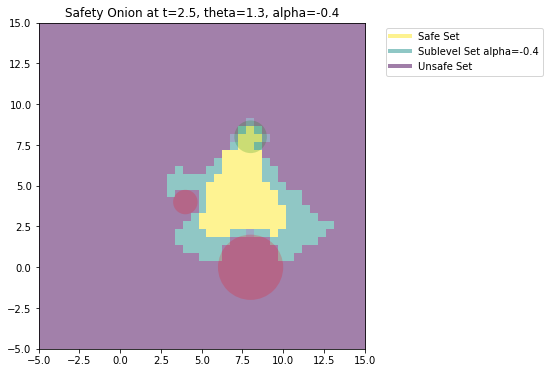

In [23]:
#@title Visualizing the Safety Onion {run: "auto"}
#@markdown (Double click here to reveal plotting code)
from matplotlib.lines import Line2D

alpha = -0.38# @param {type:"slider", min:-1, max:0,step:0.01}
theta = 1.19# @param {type:"slider", min:-3.14, max:3.14,step:0.01}
t = 2.42 # @param {type:"slider", min:0, max:5,step:0.01}

# Snap slider input to grid
theta_ind = np.argmin(np.abs(grid.axes[2]-theta))
t_ind = np.argmin(np.abs(specs.t_vec-t))
theta_val,t_val = grid.axes[2][theta_ind],specs.t_vec[t_ind]

# Build custom legend via creating fake lines
fake_lines = [Line2D([0], [0], color=plt.cm.viridis_r(0), lw=4,alpha=.5),
              Line2D([0], [0], color=plt.cm.viridis_r(.5), lw=4,alpha=.5),
              Line2D([0], [0], color=plt.cm.viridis_r(1.), lw=4,alpha=.5)]
legend = ['Safe Set', f'Sublevel Set alpha={alpha:.1f}', 'Unsafe Set']

# Safety Onion Image
title = f'Safety Onion at t={t_val:.1f}, theta={theta_val:.1f}, alpha={alpha:.1f}'
img = np.sign(V_plot[:,:,theta_ind,t_ind])*.5+np.sign(V_plot[:,:,theta_ind,t_ind]-alpha)*.5

# Plot
plt.figure(figsize=(6,6))
plt.title(title)
plt.imshow(img,extent=plt_extent,origin='lower',alpha=.5,cmap='viridis_r')
plot_2d_map(specs.target,specs.obstacles)
plt.gca().legend(fake_lines,legend, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## Final thoughts
A major speedup we exploited in this code was the fact that the dynamics totally decoupled the disturbance from the control:
<center>
$\dot{x} = \begin{bmatrix}
\dot{\textrm{x}} \\ \dot{\textrm{y}} \\ \dot{\theta}\end{bmatrix}
=\begin{bmatrix}
v \cos(\theta) +d \sin(\theta) \\ 
v \sin(\theta) +d \cos(\theta) \\
u \end{bmatrix}$
</center>

Think about how you might solve this problem in the case where the dynamics are more complicated and there does exist coupling between the terms, or when there are more disturbance terms. Remember that in the case of coupling, you must solve it in such a way that gives the disturbance the instantaneous advantage. Consider, for example, the more complete planar car model where the control inputs are _acceleration_ $a$ and _steering angle_ $\delta$, and there are two disturbance inputs: _sideslip_ $d_S$ and _drag_ $d_D$.
<center>
$\dot{x} = \begin{bmatrix}
\dot{\textrm{x}} \\ \dot{\textrm{y}} \\ \dot{\theta}\\\dot{v}\end{bmatrix}
=\begin{bmatrix}
v \cos(\theta) +d_S \sin(\theta) \\ 
v \sin(\theta) +d_S \cos(\theta) \\
v\cdot\tan(\delta)/b \\
a-d_D\end{bmatrix}$
</center>

Can you find an analytic solution to $\displaystyle\min_{a,\delta}\max_{d_S,d_D} V(f(x,a,\delta,d_S,d_D))$?

Think about how you would solve it, and if you're feeling ambitious, copy and paste the code above to try out your solution. Be sure to redefine the `dynamics_discrete` and `dynamics_continuous` functions defined in the first block. The code is written very generally, and is quite easily extendable to four or more dimensions... but be prepared for longer computation times!

If you plan to use these techniques in your own work, you might consider using an external library that's been optimized to take advantage of efficient computational methods to solve this for you.

- In Python: https://github.com/SFU-MARS/optimized_dp <br>
- In MATLAB: https://github.com/HJReachability/helperOC (uses Level Set Toolbox)

Stay safe! (And reachable!)
